In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

***
***
# Classifying Qwerties with a complex multilayerd ANN.
- using more layers than in the previous project
- trying to fix model performance inconsistency, where it either epically fails or works surprisingly good.
- Will do another parametric experiment with various fixed learning rates and gauge model performance.

In [2]:
# creating dataset
def create_data_cloud(num_per_cluster, blur_value):
    # center of data cloud
    A = [1,3]
    B = [1,-2]

    # generating data points
    a = [A[0]+np.random.randn(num_per_cluster)*blur_value, A[1]+np.random.randn(num_per_cluster)*blur_value]
    b = [B[0]+np.random.randn(num_per_cluster)*blur_value, B[1]+np.random.randn(num_per_cluster)*blur_value]

    # category labels (dummy or 'hot' encoding)
    labels_np = np.vstack((np.zeros((num_per_cluster,1)), np.ones((num_per_cluster, 1)))) # all of dataset a is labeled as 0, all of b as 1

    # concatenate data into matrix
    data_np = np.hstack((a,b)).T

    # convert numpy matrix to pytorch tensor
    data = torch.tensor(data_np).float()
    labels = torch.tensor(labels_np).float()

    return data, labels

***
## Model Architecture
- interesting to note that the layers are in a linear-nonlinear pair
- size of output from a previous layer must match size for the input of the next layer
- **Because each node or preceptron is using a dot product operation, the inner dimensions of layers must have the same number.**


$MXN \sdot NXZ$ is valid since $N == N$.


$MXN \sdot YXZ$ is *not* valid because $N \not= Y$.
    
    
- `nn.Linear(2,16)` - this initial input layer must take input with a size / dimension of 2, because (x,y) coordinates are being passed in from the data set. 
        - This is the layer where real-world data is passed in. The size of the data passed in is NOT arbitrary. Mostly the other dimensions are.
        - 16 is the size of the output from this layer. This number choice is mostly arbitrary, but it must match the input of the hidden layer.

- `nn.ReLU()` - sizes do not need to be specified for this layer


- `nn.Linear(16,1)` - the hidden layer. Input must be a size of 16 to ensure compatibility with output of the first layer.

    
- `nn.Linear(1,1)` - the output layer. Input must be 1, because of the output from the hidden layer. 
        - The output size of this layer MUST BE 1. This is because we want the model to only produce one categorization of the data point.
    

- `nn.Sigmoid()` - final activation layer. Better and more stable versions built into cost functions like `nn.BCEWithLogitsLoss()`.
        - included for illustrative purposes.

- If there is a mistake with the dimensions of layers, an error like this would show up:
`RuntimeError: mat1 and mat2 shapes cannot be multiplied ( <some dimesnions> and <some other dimensions>)`

In [3]:
# building multi-layer model
def ANN_classify_build(m_learning_rate):
    ANN_classify = nn.Sequential(
        nn.Linear(2,16), # input layer
        nn.ReLU(),       # activation unit
        nn.Linear(16,1), # hidden layer
        nn.ReLU(),       # activation unit
        nn.Linear(1,1),  # output unit
        nn.Sigmoid()     # final activation
    )

    # model functions
    loss_func = nn.BCELoss() # not recommended, use nn.BCEWithLogitsLoss() instead.
    optimizer = torch.optim.SGD(ANN_classify.parameters(), lr=m_learning_rate)
    
    return ANN_classify, loss_func, optimizer

In [4]:
# training model
def ANN_classify_training(model, loss_function, m_optimizer, input_data, input_labels, epochs = 1000):
    
    # parameters
    losses = torch.zeros(epochs)

    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = model(input_data)

        # calculating loss
        loss = loss_function(y_hat, input_labels)
        losses[epoch_IDX] = loss

        # backprop
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

    # final forward pass
    final_predictions = model(input_data) # final predictions from fully trained model

    # calculating accuracy based on if predicted label == actual label
    # using 0.5 because data is not raw output. 0.5 is the decision boundary because the output has been put through a sigmoid function.
    decision_boundary = 0.5
    total_accuracy = 100*torch.mean(((final_predictions > decision_boundary) == input_labels).float()) # used in almost every model for categorization.

    return final_predictions,losses, total_accuracy

#### Additional notes
**What is this line really doing?**<br><br>
`total_accuracy = 100*torch.mean(((final_predictions > decision_boundary) == input_labels).float())`
- This line of code is used in almost every model that does categorization.

**Looking at each component**
- `final_predictions` is a *pytorch object* that contains the final guess for categorizing the data point for every epoch. This will be in the range of [0,1] because of the last activation unit in the model.
    - The final output is actually used as a probability, giving the chance of whether or not the data point belongs to the first category.
    - If a model is performing well, the values will either be close to zero (floor) or close to the one (ceiling), with very few points closer to the middle / decision boundary.
- `(final_predictions > decision_boundary)` produces a *boolean vector* of true and false values. Values that are true belong to the first category (with the chance being greater than 50%).
    - The **decision boundary** in this case is 0.5 (50% chance) because there are only two categories. 50% chance and greater means that the model predicted that the data point likely belongs to the first category. <50% means that the model has predicted that the data point does **not** belong to the first category. 
    - This 'converts' the numeric values outputted from the model to a label, which is common in categorization.
    - The predicted bool values will be compared to the actual assigned values.
    - Any differences between the model's categorization and actual or true categorization is a *miscategorized* value.

- `(final_predictions > decision_boundary) == input_labels)` This part of the line is where the model's categorizations are compared against the true categorizations for each value.
    - You want the True / False boolean value to map to the 1 / 0 label value of the dataset.

- `((final_predictions > decision_boundary) == input_labels).float()` This part of the line converts the True/False result inside of the parenthesis into floating point values.
    - Correct predictions would be True converted into 1.0
    - Incorrect predictions would be False converted into 0.0

- `torch.mean()` is used to take the average of the correct and incorrect predictions.
    - These have to be numbers for the average function to work.
    - This gives a decimal value.

- `100*torch.mean()` is used to convert decimal value into a percent value.

***
### Quick test of model and functions.
- This is a good idea, especially before doing a larger experiment.

Test model accuracy: 50%


<function matplotlib.pyplot.show(close=None, block=None)>

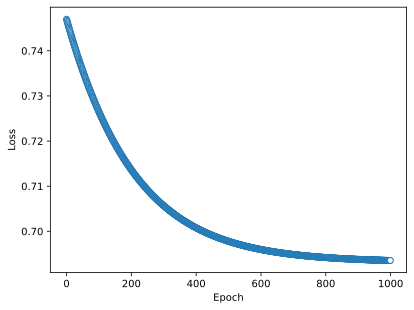

In [5]:
# quick sanity check

# generating data
n_test = 100
blur_test = 1
sanity_data, sanity_labels = create_data_cloud(n_test, blur_test)

# building model
test_model, test_loss_func, test_optimizer = ANN_classify_build(0.01)

# training model
test_predic, test_losses, test_acc = ANN_classify_training(test_model, test_loss_func, test_optimizer, sanity_data, sanity_labels)

print("Test model accuracy: %g%%"%test_acc)

# plotting losses
plt.plot(test_losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show

***
## Parametric experiment

In [6]:
# generating data
n_per_cluster = 100
blur = 1
generated_data, generated_labels = create_data_cloud(n_per_cluster, blur)

In [7]:
# setting up parametric experiment
p_learning_rates = np.linspace(0.001, 0.1, 50) # varied
p_epochs = 1000 # constant

# storing results
accuracy_each_lr = []
losses_by_run = np.zeros((len(p_learning_rates), p_epochs))

# parametric study
for i, lr_value in enumerate(p_learning_rates):

    # creating and training model
    ANN_model, ANN_loss, ANN_optimizer = ANN_classify_build(lr_value)
    results, model_losses, model_accuracy = ANN_classify_training(ANN_model, ANN_loss, ANN_optimizer, generated_data, generated_labels) # results will be between [0,1]

    # storing results for each run
    accuracy_each_lr.append(model_accuracy)
    losses_by_run[i,:] = model_losses.detach()

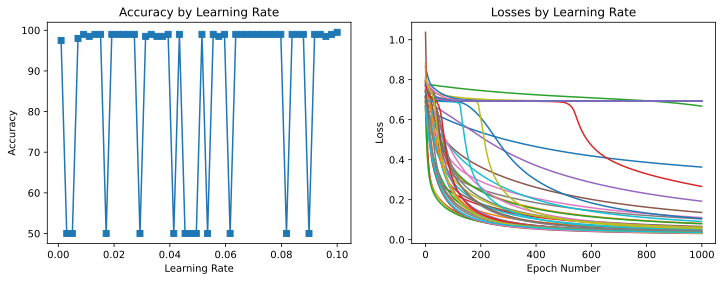

In [8]:
# plotting results
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot for accuracy
ax[0].plot(p_learning_rates,accuracy_each_lr, 's-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by Learning Rate')

# plot for losses
ax[1].plot(losses_by_run.T)
ax[1].set_xlabel('Epoch Number')
ax[1].set_ylabel('Loss')
ax[1].set_title('Losses by Learning Rate')

plt.show()

### Interpreting the results
- Adding more layers did not stablize the model behavior.
- The losses do look different, they either went to zero or didn't converge.